In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay

from mpitree.tree import DecisionTreeClassifier


In [ ]:
!mpirun -n 4 python3 -c "exec('from mpitree.tree import ParallelDecisionTreeClassifier\nfrom sklearn.datasets import load_iris\niris = load_iris()\nclf = ParallelDecisionTreeClassifier(max_depth=3).fit(iris.data[:, :2], iris.target)\nif not clf.WORLD_RANK:print(clf.export_text(feature_names=iris.feature_names, class_names=iris.target_names))')"  # noqa: E501


┌── sepal length (cm)
│  ├── sepal width (cm) [> 5.50]
│  │  ├── sepal length (cm) [> 3.60]
│  │  │  ├── setosa [<= 5.80]
│  │  │  └── virginica [> 5.80]
│  │  └── sepal length (cm) [<= 3.60]
│  │     ├── versicolor [<= 6.20]
│  │     └── virginica [> 6.20]
│  └── sepal width (cm) [<= 5.50]
│     ├── sepal length (cm) [> 2.70]
│     │  ├── setosa [<= 5.30]
│     │  └── setosa [> 5.30]
│     └── sepal length (cm) [<= 2.70]
│        ├── setosa [<= 4.90]
│        └── versicolor [> 4.90]


In [7]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target

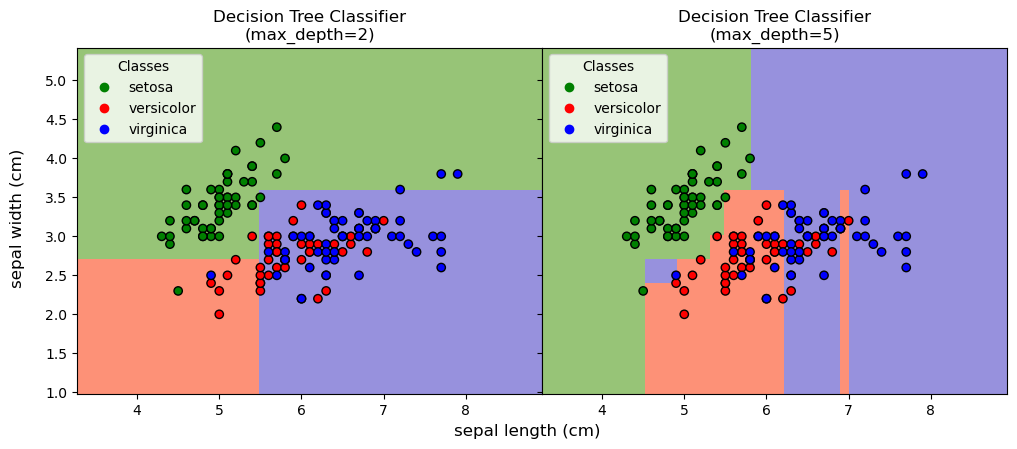

In [8]:
fig, axs = plt.subplots(
    ncols=2,
    sharex="col",
    sharey="row",
    figsize=(12, 4.5),
    # facecolor="#ded7b7fb",
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for ax, depth in zip(axs, (2, 5)):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        ax=ax,
        cmap=ListedColormap(["#97c477", "#fd9177", "#9791dd"]),
    )
    scatter = disp.ax_.scatter(
        X[:, 0],
        X[:, 1],
        cmap=ListedColormap(["#008000", "#ff0000", "#0000ff"]),
        c=y,
        edgecolors="k",
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="upper left",
        title="Classes",
    )
    _ = disp.ax_.set_title(f"Decision Tree Classifier\n(max_depth={depth})")

fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)", x=0.069)

plt.show()

In [9]:
clf = DecisionTreeClassifier(max_depth=5).fit(X, y)
print(
    clf.export_text(
        feature_names=iris.feature_names, class_names=iris.target_names, precision=1
    )
)

┌── sepal length (cm)
│  ├── sepal width (cm) [> 5.5]
│  │  ├── sepal length (cm) [> 3.6]
│  │  │  ├── setosa [<= 5.8]
│  │  │  └── virginica [> 5.8]
│  │  └── sepal length (cm) [<= 3.6]
│  │     ├── sepal length (cm) [> 6.2]
│  │     │  ├── sepal length (cm) [<= 7.0]
│  │     │  │  ├── virginica [<= 6.9]
│  │     │  │  └── versicolor [> 6.9]
│  │     │  └── virginica [> 7.0]
│  │     └── sepal length (cm) [<= 6.2]
│  │        ├── sepal width (cm) [> 5.7]
│  │        │  ├── versicolor [<= 2.9]
│  │        │  └── versicolor [> 2.9]
│  │        └── sepal width (cm) [<= 5.7]
│  │           ├── versicolor [<= 2.8]
│  │           └── versicolor [> 2.8]
│  └── sepal width (cm) [<= 5.5]
│     ├── sepal length (cm) [> 2.7]
│     │  ├── sepal width (cm) [> 5.3]
│     │  │  ├── versicolor [<= 3.0]
│     │  │  └── setosa [> 3.0]
│     │  └── setosa [<= 5.3]
│     └── sepal length (cm) [<= 2.7]
│        ├── sepal length (cm) [<= 4.9]
│        │  ├── sepal width (cm) [> 4.5]
│        │  │  ├── vers

In [10]:
x_dim = np.arange(1, 250, 10)
y_dim = np.empty_like(x_dim)

for i, x in enumerate(x_dim):
    X = np.arange(x).reshape(-1, 1)
    y = np.arange(len(X))

    start = time.time()
    DecisionTreeClassifier().fit(X, y)
    end = time.time()

    y_dim[i] = (end - start) * 1000

In [11]:
time_data = pd.read_csv("time_data.csv", header=None)

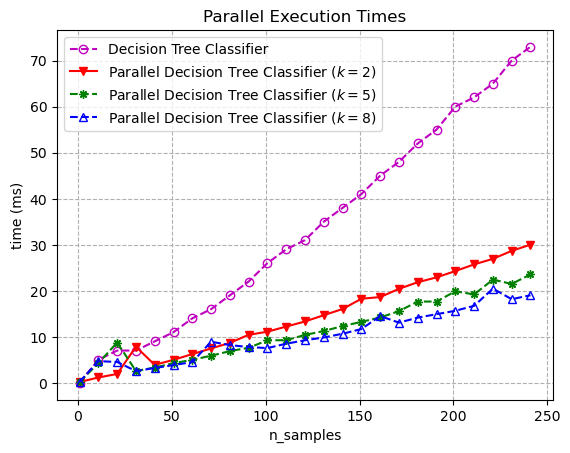

In [12]:
fig = plt.figure()
# fig.set_facecolor("#ded7b7fb")
ax = fig.add_subplot()

ax.plot(
    x_dim,
    y_dim,
    c="m",
    marker="o",
    ls="--",
    label="Decision Tree Classifier",
    fillstyle="none",
)

ax.plot(
    x_dim,
    time_data.iloc[0],
    c="r",
    marker="v",
    ls="-",
    label="Parallel Decision Tree Classifier $(k=2)$",
)

ax.plot(
    x_dim,
    time_data.iloc[1],
    c="g",
    marker=(8, 2, 0),
    ls="--",
    label="Parallel Decision Tree Classifier $(k=5)$",
)

ax.plot(
    x_dim,
    time_data.iloc[2],
    c="b",
    marker="^",
    ls="--",
    label="Parallel Decision Tree Classifier $(k=8)$",
    fillstyle="none",
)

# ax.set_facecolor("#fff4c4")
ax.set_xlabel("n_samples")
ax.set_ylabel("time (ms)")

plt.title("Parallel Execution Times")
plt.legend(loc=2)
plt.grid(ls="--")
plt.show()